In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# load the data
resultats_1 = pd.read_excel("./data/resultats_circonscription_tour_1.xlsx")
resultats_2 = pd.read_excel("./data/resultats_circonscription_tour_2.xlsx")
candidats_1 = pd.read_excel("./data/candidatures_tour_1.xlsx")
candidats_2 = pd.read_excel("./data/candidatures_tour_2.xlsx")

In [ ]:
# normalize the data
resultats_1["Code circonscription législative"] = resultats_1["Code circonscription législative"].astype(str).str.zfill(4)
resultats_2["Code circonscription législative"] = resultats_2["Code circonscription législative"].astype(str).str.zfill(4)
candidats_1["Code circonscription"] = candidats_1["Code circonscription"].astype(str).str.zfill(4)
candidats_2["Code circonscription"] = candidats_2["Code circonscription"].astype(str).str.zfill(4)

# remove outside french metropole
outre_mer_codes = ['ZA', 'ZM', 'ZD', 'ZB','ZC', 'ZN', 'ZS', 'ZX', 'ZW', 'ZP', 'ZZ', 971, 972, 973, 974, 975, 976, 986, 987, 988]

# Separate the mainland and overseas territories
resultats_1 = resultats_1[~resultats_1['Code département'].isin(outre_mer_codes)]
resultats_2 = resultats_2[~resultats_2['Code département'].isin(outre_mer_codes)]

In [48]:
print(resultats_1.columns)

Index(['Code département', 'Libellé département',
       'Code circonscription législative',
       'Libellé circonscription législative', 'Inscrits', 'Votants',
       '% Votants', 'Abstentions', '% Abstentions', 'Exprimés',
       ...
       'Elu 18', 'Numéro de panneau 19', 'Nuance candidat 19',
       'Nom candidat 19', 'Prénom candidat 19', 'Sexe candidat 19', 'Voix 19',
       '% Voix/inscrits 19', '% Voix/exprimés 19', 'Elu 19'],
      dtype='str', length=189)


In [49]:
print(candidats_2["Code nuance"].unique())

<StringArray>
[ 'RN',  'LR', 'ENS',  'UG', 'UXD', 'DVD', 'DVG', 'HOR', 'DVC', 'REG', 'UDI',
 'EXD', 'DIV', 'ECO', 'DSV',  'FI', 'SOC']
Length: 17, dtype: str


In [50]:
def get_best_candidate(resultats_canton_1):
    # return the winner of the first round
    dict_nuance_votes_1 = {}
    for i in range(1, 4):
        nuance_candidat = resultats_canton_1[f"Nuance candidat {i}"]
        if pd.isna(nuance_candidat):
            continue
        votes_candidat = resultats_canton_1[f"Voix {i}"]
        dict_nuance_votes_1[nuance_candidat] = dict_nuance_votes_1.get(nuance_candidat, 0) + votes_candidat
    return max(dict_nuance_votes_1, key=dict_nuance_votes_1.get)


In [216]:
CATEGORIES_POLITIQUES = {
    "DXG" : "Marxistes/Divers Extrèmes gauche",
    "EXG" : "Extrème gauche",
    "RDG" : "Parti radical de gauche",

    "NUP" : "Nupes",
    "UG" : "Union de la gauche",
    "PS" : "Parti Socialiste",
    "DVG" : "Divers gauche",
    "ECO" : "Ecologistes",

    "UDI" : "Union des démocrates et indépendants",
    "DVC" : "Divers centre",
    "HOZ" : "Horizons",
    "ENS" : "Ensemble (majorité présidentielle)",

    "LR" : "Les Républicains",
    "DVD" : "Divers droite",

    "UXD" : "Union Extrème droite (Ciotti)",
    "RN" : "Rassemblement National",
    "EXD" : "Extrème droite",
    "REC" : "Reconquête",
    "DSV" : "Droite souverainiste",

    "REG" : "Régionaliste",
    "DIV" : "Divers",
    "LLR" : "Lassale",
}

CATEGORIES_POLITIQUES = {
    "DXG" : 0,
    "EXG" : 0.05,
    "RDG" : 0.1,
    "FI" : 0.15,

    "NUP" : 0.15,
    "UG" : 0.2,
    "ECO" : 0.25,
    "DVG" : 0.2,
    "PS" : 0.35,
    "SOC" : 0.35,

    "UDI" : 0.5,
    "DVC" : 0.5,
    "HOZ" : 0.5,
    "HOR" : 0.5,
    "ENS" : 0.5,

    "LR" : 0.55,
    "DVD" : 0.65,

    "UXD" : 0.9,
    "RN" : 1.3,
    "EXD" : 0.9,
    "REC" : 0.85,
    "DSV" : 0.9,

    "REG" : 0.9,
    "DIV" : 0.5,
    "LLR" : 0.2,
    "COM" : 0.2,
    "VEC" : 0.5,
}

In [217]:
def get_predictions(resultats_circ, candidats_circ):
    # return the predicted winner of the second round
    dict_nuance_votes_1 = {}
    dict_nuance_votes_2 = {}
    for i in range(1, 15):
        nuance_candidat = resultats_circ[f"Nuance candidat {i}"]
        if pd.isna(nuance_candidat):
            continue
        votes_candidat = resultats_circ[f"Voix {i}"]
        dict_nuance_votes_1[nuance_candidat] = dict_nuance_votes_1.get(nuance_candidat, 0) + votes_candidat
    for index, row in candidats_circ.iterrows():
        nuance_candidat = row["Code nuance"]
        sortant = row["Sortant"] == "OUI"
        dict_nuance_votes_2[nuance_candidat] = 0

    # construct the lagrange polynomial
    lagrange_list = []
    for key, value in dict_nuance_votes_1.items():
        lagrange_list.append((CATEGORIES_POLITIQUES[key], value))
    degree = len(lagrange_list)
    
    for key, value in dict_nuance_votes_1.items():
        if key in dict_nuance_votes_2:
            dict_nuance_votes_2[key] += value
        else:
            total_distance = 0
            shortest_distances = []
            all_distances = []
            for key_2 in dict_nuance_votes_2.keys():
                distance = abs(CATEGORIES_POLITIQUES[key] - CATEGORIES_POLITIQUES[key_2])
                total_distance += distance
                all_distances.append(distance)
                # store the 2 shortest distances
                if len(shortest_distances) < 2:
                    shortest_distances.append((distance, key_2))
                else:
                    # replace the longest distance if the new one is shorter
                    longest_distance = max(shortest_distances, key=lambda x: x[0])
                    if distance < longest_distance[0]:
                        shortest_distances.remove(longest_distance)
                        shortest_distances.append((distance, key_2))
            
            # we do total_distance/distance and then normalize
            total_distance = 0
            if len(shortest_distances) == 0:
                print(f"Warning: no distances found for key {key}")
                print(dict_nuance_votes_2)
                print(dict_nuance_votes_1)
                continue
            elif len(shortest_distances) == 1:
                total_distance = shortest_distances[0][0]
            else:
                total_distance = shortest_distances[0][0] + shortest_distances[1][0]

            norm_term = 0
            for distance in all_distances:
                if distance == 0:
                    distance = 0.01
                norm_term += total_distance / distance
            
            if norm_term == 0:
                print(f"Warning: total distance is zero for key {key}")
                print(dict_nuance_votes_2)
                print(dict_nuance_votes_1)
                continue
            for key_2 in dict_nuance_votes_2.keys():
                # check if key_2 is in the 2 shortest distances
                #if key_2 in [k for d, k in shortest_distances]:
                distance = abs(CATEGORIES_POLITIQUES[key] - CATEGORIES_POLITIQUES[key_2])
                if distance == 0:
                    distance = 0.01
                # print(f"le parti {key} a une distance de {distance} avec le parti {key_2}, je met donc {((total_distance / distance) / norm_term)} votes pour le parti {key_2}")
                dict_nuance_votes_2[key_2] += value * (((total_distance / distance) / norm_term))

    return max(dict_nuance_votes_2, key=dict_nuance_votes_2.get)

In [218]:
get_predictions(resultats_1.iloc[0], candidats_2[candidats_2["Code circonscription"] == "0101"])

'LR'

In [219]:
rows = []
count_already_elected = 0
count_no_candidates = 0
print(resultats_1.shape)
for index, row in resultats_1.iterrows():
    number_canton = row["Code circonscription législative"]
    number_canton_v2 = f"{number_canton:04d}" if len(str(number_canton)) < 4 else str(number_canton)
    candidats_2_circ = candidats_2[candidats_2["Code circonscription"] == number_canton]
    if candidats_2_circ.empty:
        # print(f"No candidates for canton {number_canton} in tour 2")
        count_no_candidates += 1
        continue
    predicted_winner_nuance = get_predictions(row, candidats_2_circ)
    results_tour_2_rows = resultats_2[((resultats_2["Code circonscription législative"] == number_canton_v2) | (resultats_2["Code circonscription législative"] == number_canton))]
    if results_tour_2_rows.empty:
        # print(f"No results for canton {number_canton_v2} in tour 2")
        count_already_elected += 1
    else:
        true_winner_nuance = get_best_candidate(results_tour_2_rows.iloc[0])
        rows.append({
            "id_circ": number_canton_v2,
            "predicted_winner": predicted_winner_nuance,
            "correct_winner": true_winner_nuance
        })
dataframe_predictions = pd.DataFrame(rows, columns=["id_circ", "predicted_winner", "correct_winner"])
print(f"Number of cantons where the winner was already elected in the first round: {count_no_candidates}")

(539, 189)
Number of cantons where the winner was already elected in the first round: 73


In [220]:
# print the predictions
percentage_correct_predictions = (dataframe_predictions["predicted_winner"] == dataframe_predictions["correct_winner"]).mean() * 100
print(f"Percentage of correct predictions: {percentage_correct_predictions:.2f}%")
print(dataframe_predictions.shape)

# predicted winner distribution
# UG
print(f"predicted UG: {dataframe_predictions[(dataframe_predictions['predicted_winner'] == 'UG') & (dataframe_predictions['correct_winner'] == 'UG')].shape[0]}, correct UG: {dataframe_predictions['correct_winner'].value_counts()['UG']}, wrong UG: {dataframe_predictions[(dataframe_predictions['predicted_winner'] == 'UG') & (dataframe_predictions['correct_winner'] != 'UG')].shape[0]}")
# ENS
print(f"predicted ENS: {dataframe_predictions[(dataframe_predictions['predicted_winner'] == 'ENS') & (dataframe_predictions['correct_winner'] == 'ENS')].shape[0]}, correct ENS: {dataframe_predictions['correct_winner'].value_counts()['ENS']}, wrong ENS: {dataframe_predictions[(dataframe_predictions['predicted_winner'] == 'ENS') & (dataframe_predictions['correct_winner'] != 'ENS')].shape[0]}")
# RN
print(f"predicted RN: {dataframe_predictions[(dataframe_predictions['predicted_winner'] == 'RN') & (dataframe_predictions['correct_winner'] == 'RN')].shape[0]}, correct RN: {dataframe_predictions['correct_winner'].value_counts()['RN']}, wrong RN: {dataframe_predictions[(dataframe_predictions['predicted_winner'] == 'RN') & (dataframe_predictions['correct_winner'] != 'RN')].shape[0]}")
# LR
print(f"predicted LR: {dataframe_predictions[(dataframe_predictions['predicted_winner'] == 'LR') & (dataframe_predictions['correct_winner'] == 'LR')].shape[0]}, correct LR: {dataframe_predictions['correct_winner'].value_counts()['LR']}, wrong LR: {dataframe_predictions[(dataframe_predictions['predicted_winner'] == 'LR') & (dataframe_predictions['correct_winner'] != 'LR')].shape[0]}")
# DVD
print(f"predicted DVD: {dataframe_predictions[(dataframe_predictions['predicted_winner'] == 'DVD') & (dataframe_predictions['correct_winner'] == 'DVD')].shape[0]}, correct DVD: {dataframe_predictions['correct_winner'].value_counts()['DVD']}, wrong DVD: {dataframe_predictions[(dataframe_predictions['predicted_winner'] == 'DVD') & (dataframe_predictions['correct_winner'] != 'DVD')].shape[0]}")
# HOR
print(f"predicted HOR: {dataframe_predictions[(dataframe_predictions['predicted_winner'] == 'HOR') & (dataframe_predictions['correct_winner'] == 'HOR')].shape[0]}, correct HOR: {dataframe_predictions['correct_winner'].value_counts()['HOR']}, wrong HOR: {dataframe_predictions[(dataframe_predictions['predicted_winner'] == 'HOR') & (dataframe_predictions['correct_winner'] != 'HOR')].shape[0]}")
# DVC
print(f"predicted DVC: {dataframe_predictions[(dataframe_predictions['predicted_winner'] == 'DVC') & (dataframe_predictions['correct_winner'] == 'DVC')].shape[0]}, correct DVC: {dataframe_predictions['correct_winner'].value_counts()['DVC']}, wrong DVC: {dataframe_predictions[(dataframe_predictions['predicted_winner'] == 'DVC') & (dataframe_predictions['correct_winner'] != 'DVC')].shape[0]}")
# UDI
print(f"predicted UDI: {dataframe_predictions[(dataframe_predictions['predicted_winner'] == 'UDI') & (dataframe_predictions['correct_winner'] == 'UDI')].shape[0]}, correct UDI: {dataframe_predictions['correct_winner'].value_counts()['UDI']}, wrong UDI: {dataframe_predictions[(dataframe_predictions['predicted_winner'] == 'UDI') & (dataframe_predictions['correct_winner'] != 'UDI')].shape[0]}")

print(dataframe_predictions["correct_winner"].value_counts())

Percentage of correct predictions: 92.49%
(466, 3)
predicted UG: 134, correct UG: 141, wrong UG: 13
predicted ENS: 134, correct ENS: 139, wrong ENS: 9
predicted RN: 75, correct RN: 86, wrong RN: 7
predicted LR: 34, correct LR: 38, wrong LR: 0
predicted DVD: 16, correct DVD: 22, wrong DVD: 0
predicted HOR: 5, correct HOR: 6, wrong HOR: 0
predicted DVC: 4, correct DVC: 4, wrong DVC: 0
predicted UDI: 2, correct UDI: 3, wrong UDI: 0
correct_winner
UG     141
ENS    139
RN      86
LR      38
DVD     22
UXD     16
DVG      6
HOR      6
DVC      4
REG      3
UDI      3
DIV      1
ECO      1
Name: count, dtype: int64


## Display France Map

In [221]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.patches as mpatches


# Load the GeoJSON file
gdf = gpd.read_file('./maps/carte_circonscriptions.geojson')

def plot_map_france(df_winner, gdf, title):
    # Define the department codes for the overseas territories
    outre_mer_codes = ["ZA","ZM","ZD", 'ZB','ZC', 'ZN', 'ZS', 'ZX', 'ZW', 'ZP']

    TABLE_OUTREMER = {"ZA": "Guadeloupe", "ZM": "Mayotte", "ZD": "La Réunion", "ZB": "Martinique", "ZC": "GUyane", "ZN": "Nouvelle Calédonie", "ZS": "St Pierre-et-Miquelon", "ZX": "Saint-Martin & Barthélemy", "ZW": "Wallis-et-Futuna", "ZP": "Polynésie française"}
    gdf = gdf.merge(df_winner, left_on='codeCirconscription', right_on='id_circ', how='left')
    # Separate the mainland and overseas territories
    gdf_mainland = gdf[~gdf['codeDepartement'].isin(outre_mer_codes)]
    gdf_outre_mer = gdf[gdf['codeDepartement'].isin(outre_mer_codes)]
    # Create a GridSpec object
    gs = gridspec.GridSpec(5, 8)

    party_colors = {
        "Alliance gauche": "#AA0000",
        "EXG" : "#880000",
        "DXG" : "#ff0000",
        "LFI - UP" : "#880000",
        "UG" : "#AA0000",
        "PS" : "#ff0000",
        "REG" : "#ff0000",
        "DVG" : "#ff0000",
        "EELV" : "#00ff00",
        "ECO" : "#00ff00",
        "DVC" : "#ff0000",
        "UDI" : "#ff0000",
        "ECO" : "#00ff00",
        "RDG" : "#ff0000",
        "NUP" : "#bb0000",
        "Macron": "#ff9900",
        "ENS" : "#ff9900",
        "HOZ" : "#ff9900",
        "DVC" : "#ff9900",
        "UDI" : "#ff9900",
        "LR" : "#0066ff",
        "DVD" : "#0077ff",
        "UXD" : "#0088ff",
        "RN" : "#000088",
        "Alliance droite": "#0000AA",
        "DSV" : "#0000ff",
        "REC" : "#0000ff",
        "EXD" : "#0000ff",
        "Divers" : "#00ff00",
        "DIV" : "#00ff00",
        "LLR" : "#bf8bff",  
    }
    # Define a color map based on the winner
    cmap = lambda x: party_colors.get(x, "#ffffff")  # Use black as the default color
    # Plot the mainland with colors based on the winner
    ax_mainland = plt.subplot(gs[:, 1:])
    ax_mainland.axis('off')  # Turn off the axis
    gdf_mainland.plot(ax=ax_mainland, color=gdf_mainland['Winner'].map(cmap))
    ax_mainland.set_title(title)

    # Plot the overseas territories with colors based on the winner
    # for i, code in enumerate(outre_mer_codes):
    #     ax = plt.subplot(gs[i//2, i%2])
    #     ax.axis('off')  # Turn off the axis
    #     correct_gdf = gdf_outre_mer[gdf_outre_mer['codeDepartement'] == code]
    #     if not correct_gdf.empty:
    #         gdf_outre_mer[gdf_outre_mer['codeDepartement'] == code].plot(ax=ax, color=gdf_outre_mer['Winner'].map(cmap))
    #         ax.set_title(f'{TABLE_OUTREMER[code]}', fontsize=6)  # Set the font size
    # Get the unique parties in the data        
    unique_parties = pd.concat([gdf_mainland['Winner'], gdf_outre_mer['Winner']]).unique()

    
    patches = [mpatches.Patch(color=color, label=party) for party, color in party_colors.items() if party in unique_parties]

    # Add the legend to the mainland plot
    ax_mainland.legend(handles=patches, fontsize=7, loc='upper right')

    # Show the plot
    plt.tight_layout()
    plt.show()

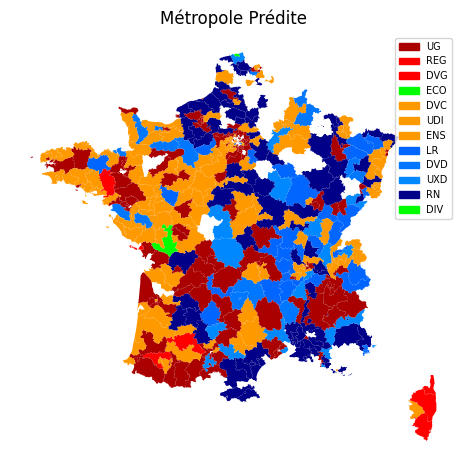

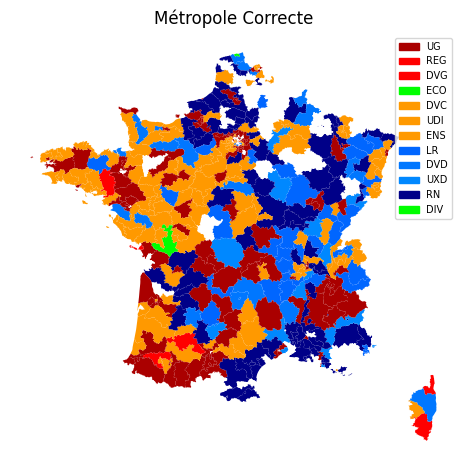

In [222]:
plot_map_france(dataframe_predictions.rename(columns={"id_circ": "id_circ", "predicted_winner": "Winner"}), gdf, "Métropole Prédite")
plot_map_france(dataframe_predictions.rename(columns={"id_circ": "id_circ", "correct_winner": "Winner"}), gdf, "Métropole Correcte")